In [1]:
from __future__ import division
import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg
import pypardiso
import pandas as pd

## Code for Laplachian and Alpha Computations

In [2]:
"""This module implements natural image matting method described in:
    Levin, Anat, Dani Lischinski, and Yair Weiss. "A closed-form solution to natural image matting."
    IEEE Transactions on Pattern Analysis and Machine Intelligence 30.2 (2008): 228-242.

"""

def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)


def compute_laplacian(img: np.ndarray, mask=None, eps: float =10**(-7), win_rad: int =1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    A = win_var + (eps/win_size)*np.eye(3)
    B = (winI - win_mu).transpose(0, 2, 1)
    X = np.linalg.solve(A, B).transpose(0, 2, 1)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + X @ B)

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()

    # rewrite L in CSR format
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
    return L


def closed_form_matting_with_prior(image, prior, prior_confidence, consts_map=None):
    """Applies closed form matting with prior alpha map to image.

    Args:
        image: 3-dim numpy matrix with input image.
        prior: matrix of same width and height as input image holding apriori alpha map.
        prior_confidence: matrix of the same shape as prior hodling confidence of prior alpha.
        consts_map: binary mask of pixels that aren't expected to change due to high
            prior confidence.

    Returns: 2-dim matrix holding computed alpha map.
    """

    assert image.shape[:2] == prior.shape, ('prior must be 2D matrix with height and width equal '
                                            'to image.')
    assert image.shape[:2] == prior_confidence.shape, ('prior_confidence must be 2D matrix with '
                                                       'height and width equal to image.')
    assert (consts_map is None) or image.shape[:2] == consts_map.shape, (
        'consts_map must be 2D matrix with height and width equal to image.')

    print('Computing Matting Laplacian.')
    laplacian = compute_laplacian(image, ~consts_map if consts_map is not None else None)
    confidence = scipy.sparse.diags(prior_confidence.ravel())
    print('Solving for alpha.')
    solution = pypardiso.spsolve(
        laplacian + confidence,
        prior.ravel() * prior_confidence.ravel()
    )
    alpha = np.minimum(np.maximum(solution.reshape(prior.shape), 0), 1)
    return alpha


def closed_form_matting_with_scribbles(image, scribbles, scribbles_confidence=100.0):
    """Apply Closed-Form matting to given image using scribbles image."""

    assert image.shape[:2] == scribbles.shape, 'scribbles must have exactly same shape as image.'
    consts_map = scribbles != 0.5
    return closed_form_matting_with_prior(
        image,
        scribbles,
        scribbles_confidence * consts_map,
        consts_map
    )

## Testing

In [18]:
image = cv2.imread("test-image.jpg", cv2.IMREAD_COLOR) / 255.0
scaled_image = cv2.resize(image, (0, 0), fx = 0.5, fy = 0.5)

scribbles = np.ones_like(scaled_image[:,:,1]) / 2

center = (10, 10)  # Example center
radius = 10 # Example radius
x, y = np.ogrid[:scribbles.shape[0], :scribbles.shape[1]]
mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

scribbles[mask] = 0.0

center = (150, 15)  # Example center
radius = 10  # Example radius
x, y = np.ogrid[:scribbles.shape[0], :scribbles.shape[1]]
mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

scribbles[mask] = 0.0

center = (15, 75)  # Example center
radius = 10  # Example radius
x, y = np.ogrid[:scribbles.shape[0], :scribbles.shape[1]]
mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

scribbles[mask] = 0.0

center = (300, 200)  # Example center
radius = 10  # Example radius
x, y = np.ogrid[:scribbles.shape[0], :scribbles.shape[1]]
mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

scribbles[mask] = 1.0

center = (50, 150)  # Example center
radius = 10  # Example radius
x, y = np.ogrid[:scribbles.shape[0], :scribbles.shape[1]]
mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

scribbles[mask] = 1.0

center = (200, 150)  # Example center
radius = 10  # Example radius
x, y = np.ogrid[:scribbles.shape[0], :scribbles.shape[1]]
mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

scribbles[mask] = 1.0

center = (50, 275)  # Example center
radius = 10  # Example radius
x, y = np.ogrid[:scribbles.shape[0], :scribbles.shape[1]]
mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

scribbles[mask] = 0.0

alpha = closed_form_matting_with_scribbles(scaled_image, scribbles)
cv2.imwrite("alpha_matte.png", alpha * 255.0)


Computing Matting Laplacian.
Solving for alpha.


True

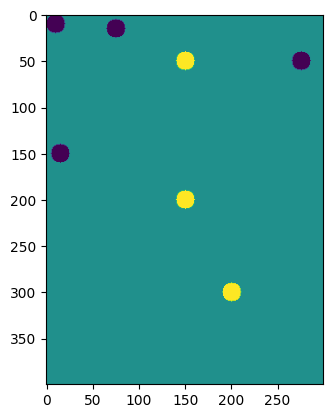

In [19]:
import matplotlib.pyplot as plt
plt.imshow(scribbles)

## Error Metrics

In [9]:
mask = cv2.imread("mask.png", cv2.IMREAD_UNCHANGED)[:,:,3]
mask = cv2.resize(mask, (0, 0), fx = 0.5, fy = 0.5)

##MSE
MSE = np.mean((alpha - mask) ** 2)

##PSNR
PSNR = 20 * np.log10(255 / np.sqrt(MSE))

##SAD
SAD = np.sum(np.abs(alpha - mask))

df = pd.DataFrame(columns = ["MSE", "PSNR", "SAD"])

df.loc["test"] = [MSE, PSNR, SAD]

df

,MSE,PSNR,SAD
test,42222.675627,1.875346,2.009405e+07


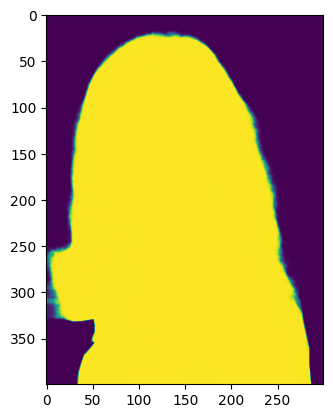

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mask)